In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
livi_dir = "/omics/groups/OE0540/internal/projects/LIVI"
benchmark_dir = os.path.join(livi_dir, "Benchmarks")

In [3]:
cis_eQTLGen = pd.read_csv(
    os.path.join(livi_dir, "eQTLGen", "cis_eQTLs", "eQTLGen_cis-eQTLs_trans-eQTLGen-disease-associated-SNPs_OneK1K-10K-HVG-HEX.tsv"),
    sep="\t"
)

In [4]:
trans_eQTLGen_sign = pd.read_csv(
    os.path.join(livi_dir, "eQTLGen", "trans_eQTLs", "trans-eQTLGen-FDR005_OneK1K.tsv"), 
    sep="\t"
)
trans_eQTLGen_sign = trans_eQTLGen_sign.assign(snp_id = [i[0]+":"+i[1] for i in trans_eQTLGen_sign.SNP_id1.str.split("_")])
trans_eQTLGen_sign = trans_eQTLGen_sign.assign(QTL = trans_eQTLGen_sign.apply(lambda x: x.Gene+"-"+x.snp_id, axis=1))

In [5]:
benchmarks = pd.DataFrame(columns=["discovered", "replicated_trans", "replicated_cis"])

In [6]:
LIVI = pd.read_csv(
    os.path.join(livi_dir, "OneK1K", "LIVI2_testing_results", "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best/2024-12-05_10-20_LIVI_700_factors_LMM_results_Ucontext_significant_BH_005_two-step.tsv"), 
    sep="\t"
)

benchmarks = pd.concat([benchmarks, 
                        pd.DataFrame([
                            [LIVI.SNP_id.nunique(),
                             LIVI.loc[LIVI.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
                             LIVI.loc[LIVI.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]
                        ], index=["LIVI"], columns=benchmarks.columns)],
                        axis=0)


In [7]:
pca_celltype = pd.read_csv(
    os.path.join(benchmark_dir, "PCA", "700_PCs", "All_celltypes_LMM_results_700-PCs-benchmark_significant_BH_005_two-step.tsv"),
    sep="\t"
)

benchmarks = pd.concat([benchmarks, 
                        pd.DataFrame([
                            [pca_celltype.SNP_id.nunique(),
                             pca_celltype.loc[pca_celltype.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
                             pca_celltype.loc[pca_celltype.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]
                        ], index=["PCA"], columns=benchmarks.columns)],
                        axis=0)


In [8]:
scITD = pd.read_csv(
    os.path.join(benchmark_dir, "scITD", "scITD_14kgenes_700_factors_900_donors", "scITD_14kgenes_700_factors_900_donors_LMM_results_Ucontext_significant_BH_005_two-step.tsv"), 
    sep="\t"
)

benchmarks = pd.concat([benchmarks, 
                        pd.DataFrame([
                            [scITD.SNP_id.nunique(),
                             scITD.loc[scITD.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
                             scITD.loc[scITD.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]
                        ], index=["scITD"], columns=benchmarks.columns)],
                        axis=0)



In [9]:
tensorqtl = pd.read_csv(
    os.path.join(benchmark_dir, "TensorQTL", "All_celltypes_results_tensorQTL-benchmark_significant_BH_005_two-step.tsv"),
    sep="\t"
)

benchmarks = pd.concat([benchmarks, 
                        pd.DataFrame([
                            [tensorqtl.SNP_id.nunique(),
                             tensorqtl.loc[tensorqtl.SNP_id.isin(trans_eQTLGen_sign.snp_id)].SNP_id.nunique(), 
                             tensorqtl.loc[tensorqtl.SNP_id.isin(cis_eQTLGen.snp_id)].SNP_id.nunique()]
                        ], index=["TensorQTL"], columns=benchmarks.columns)],
                        axis=0)



In [10]:
benchmarks = benchmarks.reset_index(names="model")
benchmarks = benchmarks.assign(
    model_group = benchmarks.apply(
        lambda x: "PCA" if "PCA" in x.model else "LIVI" if "LIVI" in x.model else "scITD" if "scITD" in x.model else "tensorQTL", 
        axis=1
    )
)

benchmarks

,model,discovered,replicated_trans,replicated_cis,model_group
0,LIVI,506,396,505,LIVI
1,PCA,217,195,211,PCA
2,scITD,363,292,362,scITD
3,TensorQTL,299,62,151,tensorQTL


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


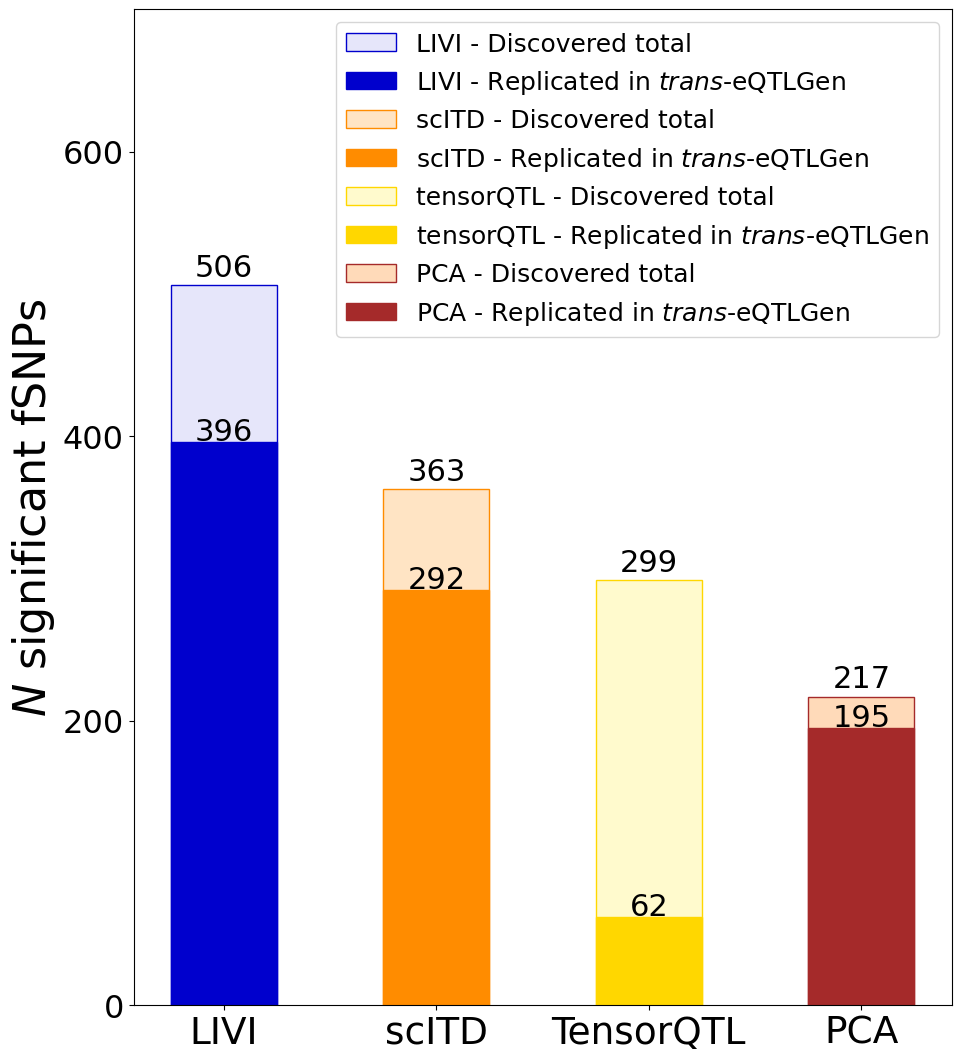

In [11]:
benchmarks_sorted = benchmarks.sort_values(by="discovered", ascending=False)
# Redefine the position dict based on the sorted dataframe
sorted_model_names = benchmarks_sorted["model"].unique()
sorted_position_dict = {name: i for i, name in enumerate(sorted_model_names)}

plot_model_names = [mn.replace(",", ",\n") if "celltype" in mn else mn for mn in sorted_model_names]

model_colors = {
    "PCA": ["peachpuff", "brown"],
    "tensorQTL": ["lemonchiffon", "gold"],
    "LIVI": ["lavender", "mediumblue"],
    "scITD": ["bisque", "darkorange"]
}

legend_handles = []
legend_labels = []


fig, axs = plt.subplots(figsize=(9.5, 10.5), constrained_layout=True)

for i, row in benchmarks_sorted.iterrows():
    pos = sorted_position_dict[row["model"]]
    color_discovered = model_colors[row["model_group"]][0]
    color_replicated = model_colors[row["model_group"]][1]
    
    # Plot the discovered bar
    bar_discovered = axs.bar(pos, row["discovered"], color=color_discovered, width=0.5, edgecolor=color_replicated)  #"black")
    if f"{row['model_group']} - Discovered total" not in legend_labels:
        legend_handles.append(bar_discovered)
        legend_labels.append(f"{row['model_group']} - Discovered total")
    
    # Plot the replicated_trans bar on top of discovered
    bar_replicated = axs.bar(pos, row['discovered'] * (row["replicated_trans"] / row["discovered"]), color=color_replicated, width=0.5, edgecolor=color_replicated) # "black")
    if f"{row['model_group']} - Replicated in $trans$-eQTLGen" not in legend_labels:
        legend_handles.append(bar_replicated)
        legend_labels.append(f"{row['model_group']} - Replicated in $trans$-eQTLGen")

    # Annotate bars with exact values
    axs.text(pos, row["discovered"]+2, str(row["discovered"]), ha="center", va="bottom", color="black", fontsize=22)
    axs.text(pos, row["discovered"] * (row["replicated_trans"] / row["discovered"])-3, str(row["replicated_trans"]), ha="center", va="bottom", color="black", fontsize=22)

axs.set_ylim(bottom=0, top=700)
axs.set_xticks(range(len(sorted_model_names)), plot_model_names, rotation=0, fontsize=27)
# axs.set_yticks(axs.get_yticks(), axs.get_yticklabels(), fontsize=18)
axs.set_yticks(np.arange(0,700, 200), np.arange(0,700,200), fontsize=23)

axs.legend(handles=[handle[0] for handle in legend_handles], labels=legend_labels, fontsize=18)

# axs.set_xlabel("Model", fontdict={"fontsize":20})
axs.set_ylabel("$N$ significant fSNPs", fontdict={"fontsize":32})
# axs.set_title("Number of SNPs with significant associations and replication in $trans$-eQTLGen",  fontdict={"fontsize":20, "fontweight":"bold"})
plt.savefig(os.path.join(benchmark_dir, "Suppl_Benchmarks_barplot.png"),
            bbox_inches="tight", dpi=500, transparent=True)
plt.savefig(os.path.join(benchmark_dir, "Suppl_Benchmarks_barplot.eps"),
            bbox_inches="tight", dpi=500, transparent=True)